In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [11]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [12]:
path_to_zip = tf.keras.utils.get_file('cats-and-dogs.zip', origin = URL, extract = True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [13]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [14]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [15]:
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 2000 files belonging to 2 classes.


In [16]:
validation_dataset = image_dataset_from_directory(
    validation_dir, 
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE
)

Found 1000 files belonging to 2 classes.


In [17]:
class_names = train_dataset.class_names

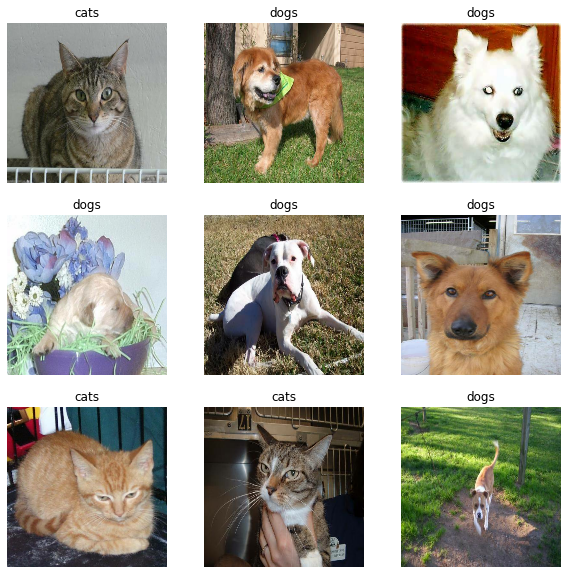

In [18]:
plt.figure(figsize = (10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [20]:
print('# of Validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('# of Test batches: %d' % tf.data.experimental.cardinality(test_dataset))

# of Validation batches: 26
# of Test batches: 6


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

In [22]:
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [23]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

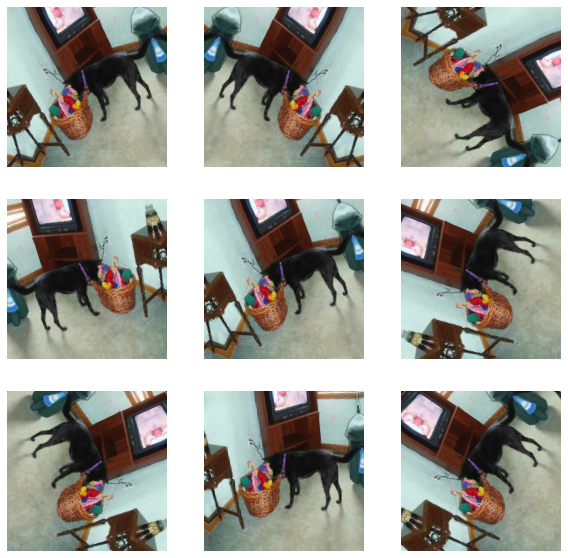

In [24]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize = (10, 10))
    first_image = image[0]
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis('off')

In [25]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset = -1)

In [26]:
IMG_SHAPE = IMG_SIZE + (3,)

In [27]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet'
)

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [29]:
base_model.trainable = False

In [30]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [32]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(32, 1)


In [33]:
inputs = tf.keras.Input(shape = (160, 160, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
base_learning_rate = 0.0001
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [36]:
len(model.trainable_variables)

2

In [37]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 106ms/step - loss: 0.7101 - accuracy: 0.5255


In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.67
initial accuracy: 0.54


In [39]:
history = model.fit(
    train_dataset,
    epochs = initial_epochs,
    validation_data = validation_dataset
)

Epoch 1/10
63/63 [==============================] - 13s 170ms/step - loss: 0.6248 - accuracy: 0.6185 - val_loss: 0.4406 - val_accuracy: 0.7141
Epoch 2/10
63/63 [==============================] - 11s 167ms/step - loss: 0.4879 - accuracy: 0.7180 - val_loss: 0.3292 - val_accuracy: 0.8193
Epoch 3/10
63/63 [==============================] - 11s 167ms/step - loss: 0.3877 - accuracy: 0.8000 - val_loss: 0.2619 - val_accuracy: 0.8762
Epoch 4/10
63/63 [==============================] - 11s 165ms/step - loss: 0.3458 - accuracy: 0.8275 - val_loss: 0.2225 - val_accuracy: 0.8985
Epoch 5/10
63/63 [==============================] - 11s 165ms/step - loss: 0.2977 - accuracy: 0.8585 - val_loss: 0.1873 - val_accuracy: 0.9233
Epoch 6/10
63/63 [==============================] - 11s 165ms/step - loss: 0.2710 - accuracy: 0.8725 - val_loss: 0.1722 - val_accuracy: 0.9332
Epoch 7/10
63/63 [==============================] - 11s 164ms/step - loss: 0.2646 - accuracy: 0.8840 - val_loss: 0.1500 - val_accuracy: 0.9468

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

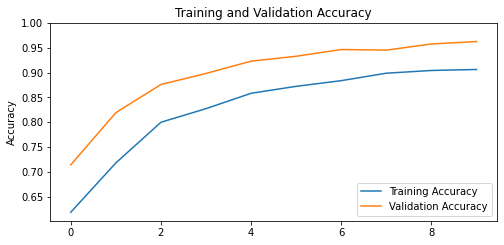

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

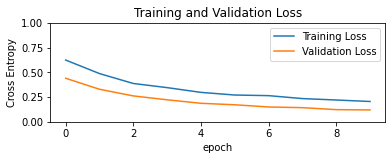

In [42]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
# Unfreeze the Top Layer of the Model
base_model.trainable = True

In [45]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [46]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
    metrics=['accuracy']
)

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [48]:
len(model.trainable_variables)

56

In [49]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset
)

Epoch 10/20
63/63 [==============================] - 18s 233ms/step - loss: 0.1627 - accuracy: 0.9289 - val_loss: 0.0516 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 15s 226ms/step - loss: 0.1286 - accuracy: 0.9432 - val_loss: 0.0457 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 14s 225ms/step - loss: 0.0920 - accuracy: 0.9647 - val_loss: 0.0408 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 15s 225ms/step - loss: 0.1086 - accuracy: 0.9551 - val_loss: 0.0435 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 14s 224ms/step - loss: 0.0953 - accuracy: 0.9629 - val_loss: 0.0560 - val_accuracy: 0.9765
Epoch 15/20
63/63 [==============================] - 14s 225ms/step - loss: 0.0883 - accuracy: 0.9670 - val_loss: 0.0393 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 15s 225ms/step - loss: 0.0746 - accuracy: 0.9687 - val_loss: 0.0274 - val_accuracy:

In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

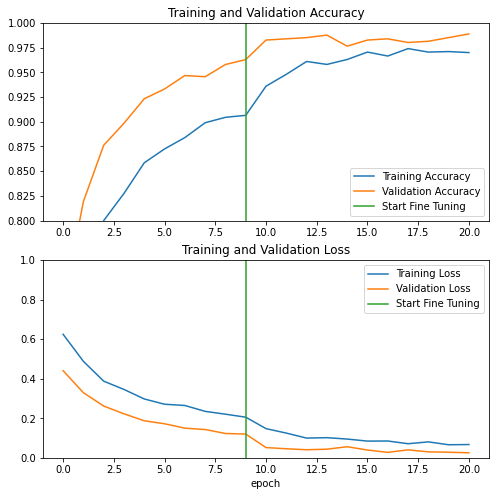

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 111ms/step - loss: 0.0605 - accuracy: 0.9688
Test accuracy : 0.96875


In [53]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [54]:
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0]
Labels:
 [0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0]


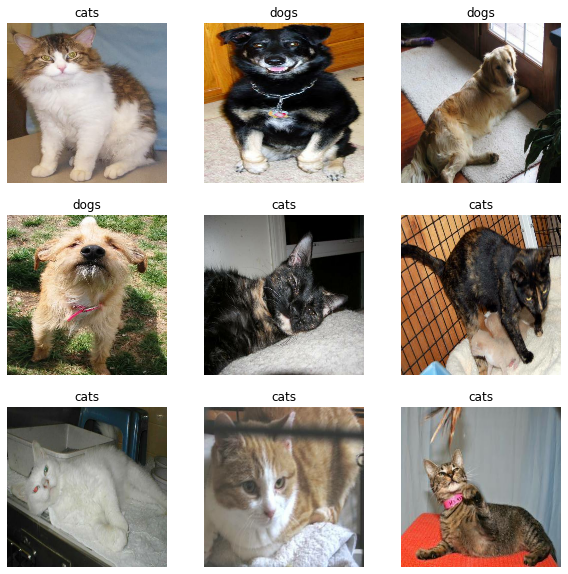

In [55]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")